## Download dataset

# Pytorch training paradigm

In this notebook we will create an image classifier to detect playing cards.

We will tackle this problem in 3 parts:
1. Pytorch Dataset
2. Pytorch Model
3. Pytorch Training Loop

Almost every pytorch model training pipeline meets this paradigm.

In [2]:
print("hello")

hello


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm # shows progression bar

import matplotlib.pyplot as plt
import torch
from torchvision.transforms import ToPILImage

# Step 1. Pytorch Dataset (and Dataloader)

- It's an organized way to structure how the data and labels are loaded into the model.
- We can then wrap the dataset in a dataloader and pytorch will handle batching the shuffling the data for us when training the model!

In [5]:
class TrafficDataset(Dataset):
  def __init__(self, data_dir, transform=None):
      self.data = ImageFolder(data_dir, transform=transform, allow_empty=True)  # allow_empty=True - some testing classes folders are empty

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
      return self.data[idx]

  @property
  def classes(self):
      return self.data.classes

In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)), # neural networks require inputs of a fixed size.
    transforms.ToTensor(),
])

data_dir = "./TrafficDataset"
training_dir = data_dir+"/Training"
testing_dir = data_dir+"/Testing"



train_dataset = TrafficDataset(training_dir, transform=transform)
# val_dataset = TrafficDataset(valid_folder, transform=transform)
test_dataset = TrafficDataset(testing_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(testing_dir, batch_size=32, shuffle=False)

In [17]:
test_loader.batch_sampler.

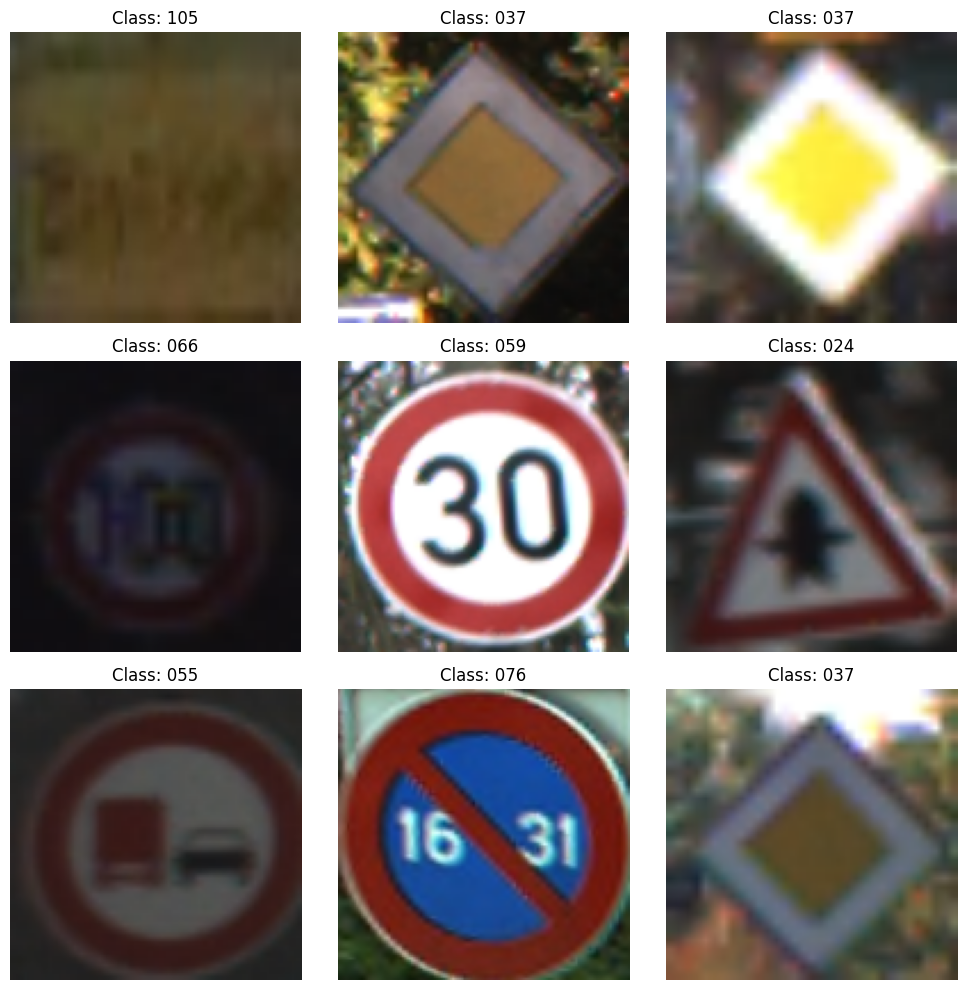

In [8]:
def visualize_dataset(dataset, num_samples=9, grid_size=(3, 3)):
    """Visualize random samples from the dataset with class labels."""
    plt.figure(figsize=(10, 10))
    indices = torch.randperm(len(dataset))[:num_samples]  # Random indices

    for i, idx in enumerate(indices):
        image, label = dataset[idx]  # Get image and label
        class_name = dataset.classes[label]  # Get class name

        if isinstance(image, torch.Tensor):
            image = ToPILImage()(image)

        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.imshow(image)
        plt.title(f"Class: {class_name}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_dataset(train_dataset, num_samples=9)

# Model

In [11]:
class TrafficClassifer(nn.Module): # nn.Module, which is the base class for all neural networks in PyTorch.
    """This class builds a custom classifier using a pretrained EfficientNet-B0 as the base and adds a new final layer for your specific number of classes (53). """
    def __init__(self, num_classes=164):
        super(TrafficClassifer, self).__init__()
        # Where we define all the parts of the model. For example it gives access to forward method
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1]) # Takes all layers of the EfficientNet except the final classification layer.

        enet_out_size = 1280 # For each image, the feature extractor gives 1280 features
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(), # Removes the unnecessary spatial dimensions (1,1)
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # It's where we connect the different layers that were defined in the __init__ method and specify how they interact to produce the final output. output = model(input)
        x = self.features(x) #  extracts the features from the image using a pre-trained model
        output = self.classifier(x) #  map features to class probabilities.
        return output


In [12]:
model = TrafficClassifer()

In [18]:
for images, labels in train_loader:
  break

example_out = model(images) # check if model accept our data
example_out.shape # [batch_size, num_classes]

torch.Size([32, 164])

# Step 3. The training loop

- Epoch: One run through the entire training dataset.

- **There are packages that package this for you, but it's good to have at least written it once to understand how it works.**

## Summary of training step:
 - Clear old gradients → zero_grad().
 - Forward pass → Compute predictions (model(images)).
 - Calculate loss → Compare predictions with truth (criterion).
 - Backpropagate → Compute gradients (backward()).
 - Update weights → Optimizer adjusts parameters (step()).
 - Track progress → Accumulate loss for reporting.


## Setup Datasets

## Simple Training Loop

In [13]:
 torch.cuda.is_available()

True

In [14]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = TrafficClassifer()
model.to(device) # Moves the model to the selected device

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Оптимизатор – это алгоритм, который обновляет веса модели на основе градиентов (чтобы минимизировать ошибку).

for epoch in range(num_epochs):
    # Training phase
    model.train() #  method is used to set a PyTorch model to training mode.
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'): # tqdm for visualization of progress
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad() #  If you don’t zero them, gradients from previous batches will add up, causing incorrect updates. Nullime gradientid
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation (computes gradients).
        optimizer.step()  # Updates model weights using gradients.
        running_loss += loss.item() * labels.size(0)  # Multiply by labels.size(0) (batch size) to account for varying batch sizes.
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(test_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Training loop:   0%|          | 0/1893 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

In [16]:
for images, labels in tqdm(test_loader, desc='Validation loop'):
    # Move inputs and labels to the device
    images, labels = images.to(device), labels.to(device)

Validation loop:   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

# Visualize Losses

We can plot our training and validation loss through this training, usually we do this at the end of each epoch. We see that our accuracy on the validation dataset is `x`! There are a LOT more things to learn about that can drastically improve how to train a model which I will cover in future videos, but this should give you a good start!



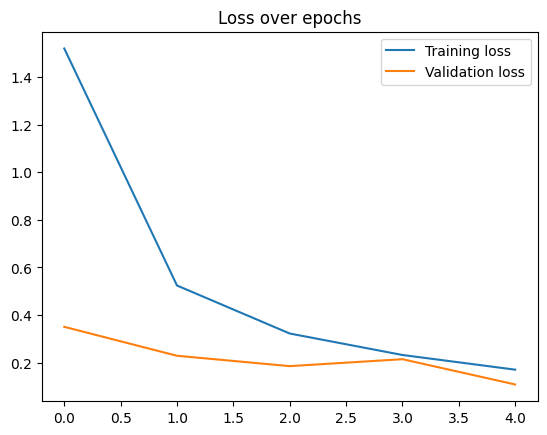

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# **Bonus:** Evaluating the Results



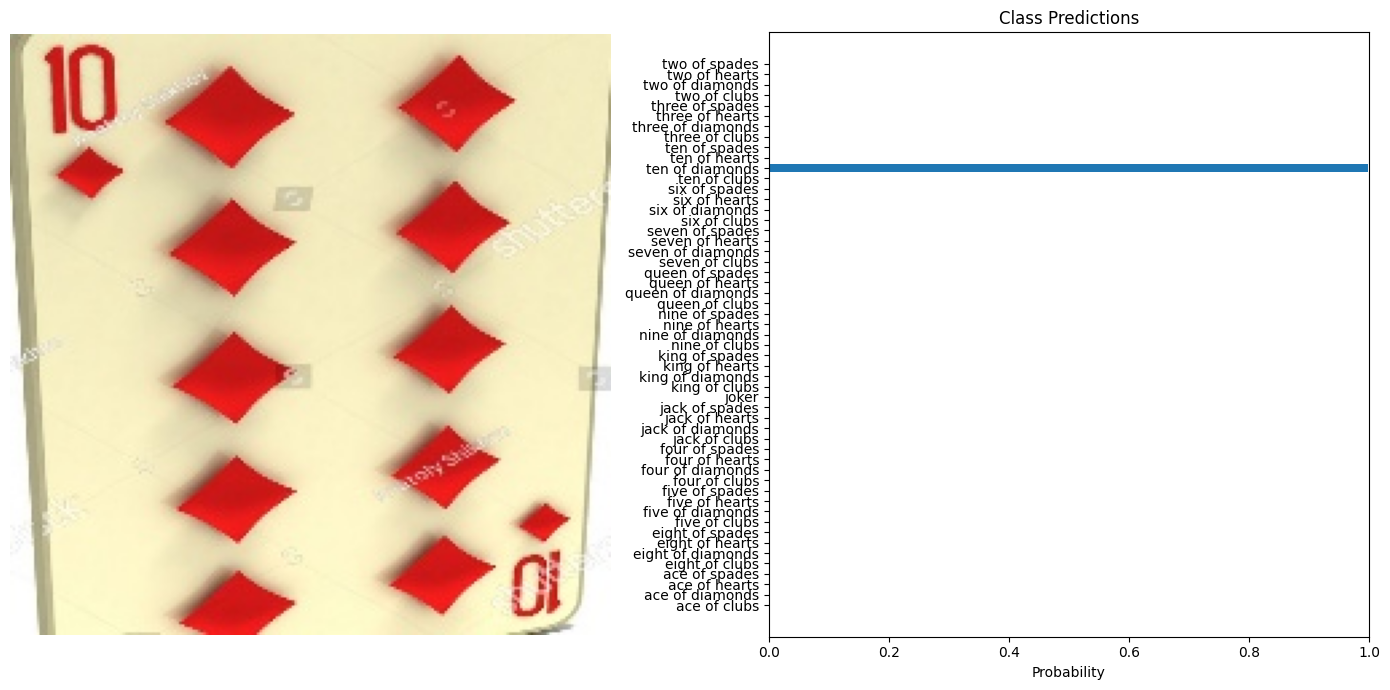

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad(): # torch.no_grad() is a context manager in PyTorch that disables gradient tracking for all operations inside its block.
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
dataset[0][0]
test_image = "/kaggle/input/cards-image-datasetclassification/test/ten of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)